<a href="https://colab.research.google.com/github/geee05/LSTM/blob/main/Amazon_Stock_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_amz=yf.download("amzn",start='2019-01-01',interval='1d')
data_amz.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000
2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000
2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000
2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000
2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000


In [ ]:
data_amz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2019-01-02 to 2023-05-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1094 non-null   float64
 1   High       1094 non-null   float64
 2   Low        1094 non-null   float64
 3   Close      1094 non-null   float64
 4   Adj Close  1094 non-null   float64
 5   Volume     1094 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 59.8 KB


In [ ]:
data_amz.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data_amz.duplicated().any()

False

In [ ]:
data_amz['Close']=pd.to_numeric(data_amz.Close,errors='coerce')

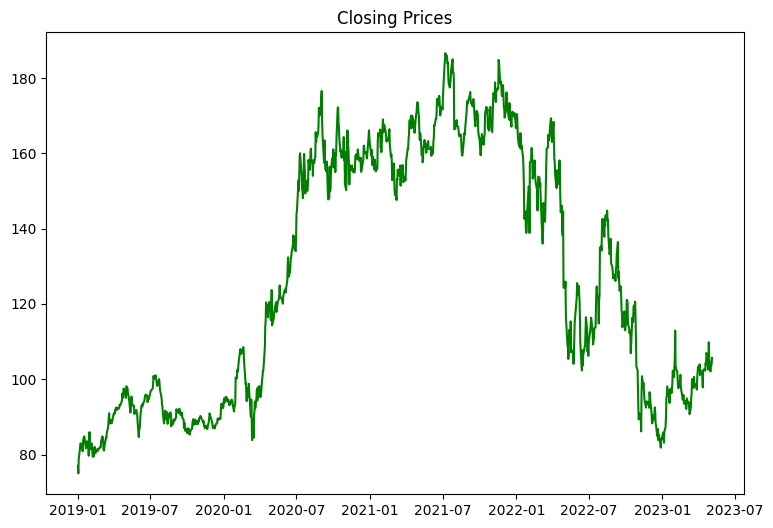

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(data_amz.index,data_amz['Close'],color='green',label='Close')
plt.title('Closing Prices')
plt.show()
#stock growth based on time

In [ ]:
data_c=data_amz.iloc[:,4:5]
data_c=data_c.values

In [ ]:
data_c

array([[ 76.95649719],
       [ 75.01399994],
       [ 78.76950073],
       ...,
       [103.65000153],
       [104.        ],
       [105.66000366]])

In [ ]:
#normalize
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_c=scaler.fit_transform(data_c)

In [ ]:
feature_length=100

In [ ]:
def xy(data_amz, feature_length):
  X=list()
  Y=list()
  for i in range(len(data_amz) - feature_length -1):
    X.append(data_amz[i:(i + feature_length),0])
    Y.append(data_amz[i + feature_length,0])
  X=np.array(X)
  Y=np.array(Y)
  return X,Y

X_train,Y_train=xy(data_c,feature_length)

In [ ]:
X_train.shape

(993, 100)

In [ ]:
#LSTM requires 3d data (tensor) as input 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape,Y_train.shape

((993, 100, 1), (993,))

In [ ]:
#model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
#adam optimiser, one dense layer, two Dropout layers, two LSTM layers

LSTMs are recurrent neural networks (RNNs): allows the network to remember the context of the model while discarding the irrelevant information.

In [ ]:
model= Sequential([
    LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],1)),
    Dropout(0.3),
    LSTM(100,return_sequences=False),
    Dropout(0.3),

    Dense(1),
])
model.compile(optimizer='adam',loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model training : 100 epochs, batch size 12
history=model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=12,
    verbose=1
)

Epoch 1/100
83/83 [==============================] - 17s 143ms/step - loss: 0.0215
Epoch 2/100
83/83 [==============================] - 12s 139ms/step - loss: 0.0061
Epoch 3/100
83/83 [==============================] - 12s 140ms/step - loss: 0.0062
Epoch 4/100
83/83 [==============================] - 12s 149ms/step - loss: 0.0047
Epoch 5/100
83/83 [==============================] - 12s 139ms/step - loss: 0.0044
Epoch 6/100
83/83 [==============================] - 11s 136ms/step - loss: 0.0045
Epoch 7/100
83/83 [==============================] - 10s 121ms/step - loss: 0.0058
Epoch 8/100
83/83 [==============================] - 12s 140ms/step - loss: 0.0047
Epoch 9/100
83/83 [==============================] - 11s 138ms/step - loss: 0.0041
Epoch 10/100
83/83 [==============================] - 11s 136ms/step - loss: 0.0041
Epoch 11/100
83/83 [==============================] - 11s 136ms/step - loss: 0.0046
Epoch 12/100
83/83 [==============================] - 11s 131ms/step - loss: 0.0037
E

In [ ]:
#model testing
test=data_amz.iloc[:,4:5]
y_real=test.iloc[feature_length+1:,0:].values
x_test=test.iloc[:,0:].values

x_test=scaler.transform(x_test)
x_test,y_test=xy(x_test,feature_length)

x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
x_test.shape,y_test.shape

In [ ]:
y_pred=model.predict(x_test)
predicted_price=scaler.inverse_transform(y_pred)

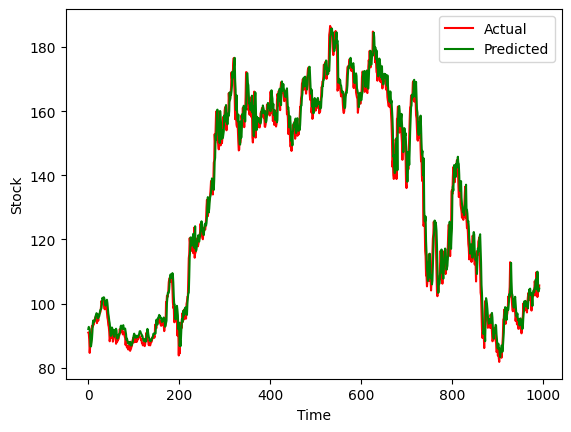

In [ ]:
plt.plot(y_real,color='red',label='Actual')
plt.plot(predicted_price,color='green',label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock')
plt.legend()
plt.show()

In [ ]:
#predictions:real time
def predict_real_time(data_amz,date,feature_length):
  if date not in data_amz.index:
    data_amz.loc[pd.Timestamp(date)] = 0
  idx=data_amz.index.get_loc(date)
  close_col=data_amz.iloc[:,4:5]
  close_col=close_col.iloc[idx - feature_length : idx, :].values
  close_col=np.expand_dims(scaler.transform(close_col),axis=0)
  prediction=model.predict(close_col)
  prediction=scaler.inverse_transform(prediction)
  return prediction

#today = datetime.today().strftime('%Y-%m-%d')
predict_real_time(data_amz,'2023-05-09',feature_length)

1/1 [==============================] - 0s 55ms/step


array([[106.523865]], dtype=float32)